In [1]:
#!/usr/bin/python
# encoding=utf8
import sys
reload(sys)
sys.setdefaultencoding('utf8')

%matplotlib inline


import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import pandas as pd
import seaborn as sns
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from redTools import *
from Kcorrect import *
################################################################# 
def add_axis(ax, xlim, ylim):
    
    x1, x2 = xlim[0], xlim[1]
    y1, y2 = ylim[0], ylim[1]
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)

    ax.minorticks_on()
    ax.tick_params(which='major', length=5, width=1.0)
    ax.tick_params(which='minor', length=2, color='#000033', width=1.0)     
    
    # additional Y-axis (on the right)
    y_ax = ax.twinx()
    y_ax.set_ylim(y1, y2)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=5, width=1.0, direction='in')
    y_ax.tick_params(which='minor', length=2, color='#000033', width=1.0, direction='in')

    # additional X-axis (on the top)
    x_ax = ax.twiny()
    x_ax.set_xlim(x1, x2)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=5, width=1.0, direction='in')
    x_ax.tick_params(which='minor', length=2, color='#000033', width=1.0, direction='in')
    

########################################################### Begin

inFile  = 'ESN_HI_catal.csv'
table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

table = extinctionCorrect(table)
table = Kcorrection(table)

band1 = 'w1'
band2 = 'w2'

if band2=='w1':
    text1 = band1+'-W1'            # example: cr-W1
    text2 = '$c21W_1$'              # example: c21w
else: 
    text1 = band1+'-W2' 
    text2 = '$c21W_2$'

delta = np.abs(table[band2]-table[band2+'_'])
index, = np.where(delta<=0.15)
table = trim(table, index)

delta = np.abs(table[band1]-table[band1+'_'])
index, = np.where(delta<=0.15)
table = trim(table, index)

table['c21w'] = table['m21'] - table[band2]
table['r_w1'] = table[band1] - table[band2]

table['Ec21w'] = np.sqrt(table['m21_e']**2+0.05**2)
table['Er_w1'] = 0.*table['r_w1']+0.1

index, = np.where(table['logWimx']>1)
table = trim(table, index)

index, = np.where(table['r_w1']<4)
table = trim(table, index)


########################################################Face-ON

## Get the initial estimations using Face-on galaxies
## AB:    a0*logWimx+b0
## Delta: alfa*X**2+beta*X+gama
AB, Delta, table, cov, Delta_e = faceON(table)
########################################################### END


pgc = table['pgc']
logWimx = table['logWimx']
logWimx_e = table['logWimx_e']
inc = table['inc']
r_w1 = table['r_w1']
c21w = table['c21w'] 
Er_w1 = table['Er_w1']
Ec21w = table['Ec21w']


C82  = table['C82_w2']   # concentration 80%/20%
mu50 = table['w2']+2.5*np.log10(2.*np.pi*(table['R50_w2']*60)**2)


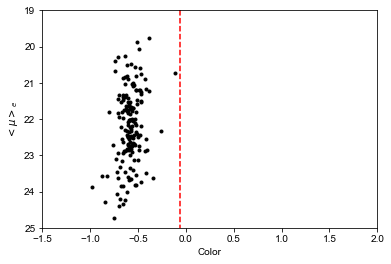

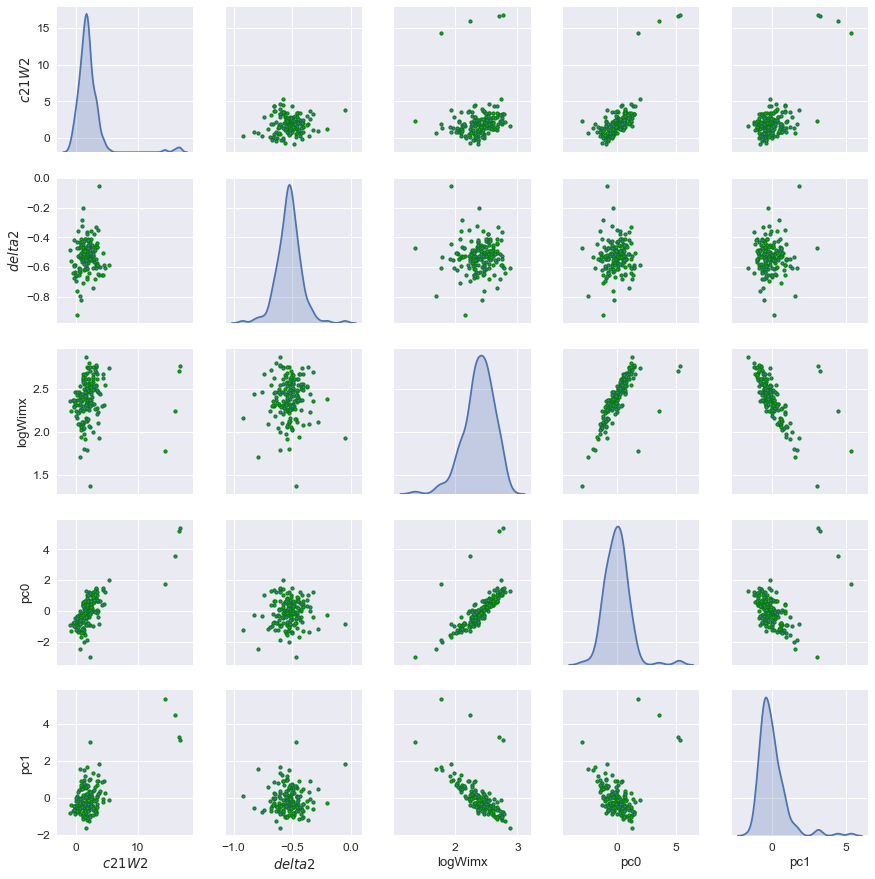

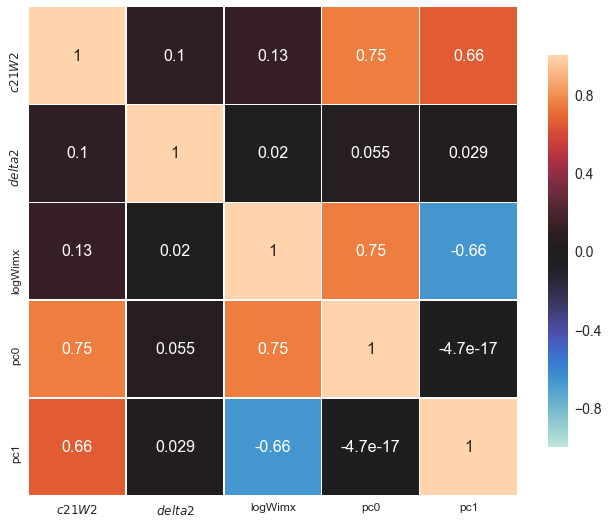

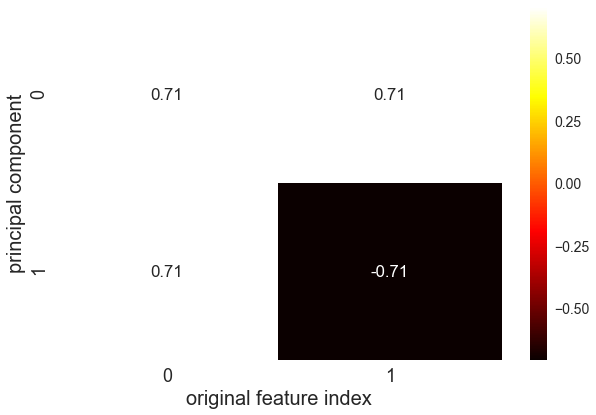

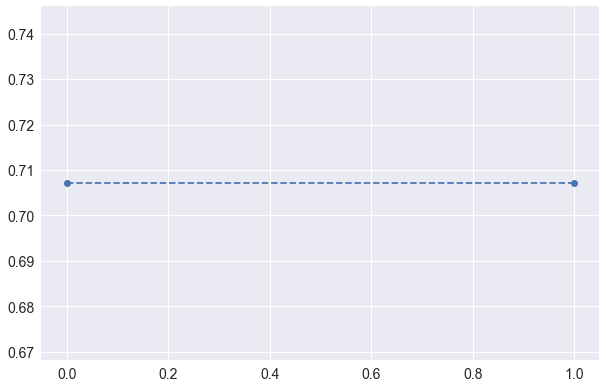

In [2]:
fig = plt.figure(figsize=(6, 4))
plt.plot(r_w1,mu50, 'k.')
a, b  = np.polyfit(mu50, r_w1, 1)
x = np.linspace(19,25,50)
y = a*x+b
plt.plot(y,x, 'r--')
plt.xlim([-1.5,2])
plt.ylim([25,19])

plt.xlabel('Color')
plt.ylabel('$<\mu>_e$')
##################################################
a0, b0  = np.polyfit(r_w1, mu50, 1)
x = np.linspace(-1.5,1.5,50)
y = a0*x+b0
#plt.plot(x,y, 'b--')

x = np.linspace(19,25,50)
#a = 0.5*(a+1./a0)
#b=0.5*(b-b0/a0)
y = a*x+b
#plt.plot(y,x, 'g--')

delta2 = r_w1 - (a*mu50+b)

##################################################

### Compute the correlation matrix
z_scaler = StandardScaler()
data = {'$c21W1$':c21w, '$logWimx$':logWimx}
d = pd.DataFrame.from_dict(data)
z_data = z_scaler.fit_transform(d)
data = PCA().fit_transform(z_data);
pca_trafo = PCA().fit(z_data);
pc0=data[:,0]; pc1=data[:,1]
d = pd.DataFrame({'$delta2$':delta2,'$c21W2$':c21w, 'logWimx':logWimx,'pc0':data[:,0],'pc1':data[:,1]})
sns.set(font_scale=1.2)
pp = sns.pairplot(d, diag_kind="kde", markers=".",plot_kws=dict(s=40, edgecolor="g", linewidth=1),diag_kws=dict(shade=True))

### Compute the correlation matrix
corr = d.corr()

### Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

### Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

### Generate a custom diverging colormap
#cmap = sns.diverging_palette(110, 20, as_cmap=False)

sns.set(font_scale=1.4)

### Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmin=-1,vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={"size": 16}, annot=True) # , mask=mask)

##################################################

n_comp =2

pca_data = pca_trafo.fit_transform(z_data)
pca_inv_data = pca_trafo.inverse_transform(np.eye(n_comp))

fig = plt.figure(figsize=(10, 6.5))
sns.heatmap(pca_trafo.inverse_transform(np.eye(n_comp)), cmap="hot", cbar=True, annot=True)
plt.ylabel('principal component', fontsize=20);
plt.xlabel('original feature index', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=18);
plt.tick_params(axis='both', which='minor', labelsize=12);

fig = plt.figure(figsize=(10, 6.5))
A = pca_trafo.explained_variance_ratio_
#A[2]=0; A[3]=0
j=n_comp-1
while j>1: 
    A[j]=0
    j=j-1
importance =  (np.matmul(A,np.abs(pca_inv_data))) # /(A[0]+A[1])
plt.plot(importance, '--o', label = 'mean')

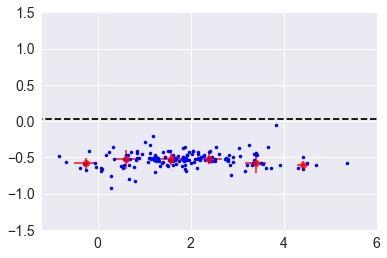

In [3]:
#indx, = np.where(delta2<0.7)
#delta2 = delta2[indx]
#c21w = c21w[indx]
#logWimx = logWimx[indx]
#pc0 = pc0[indx]
##################################################

rms = np.sqrt(np.mean(np.square(delta2)))
print(rms)   # 0.25

fig = plt.figure(figsize=(6, 4))
plt.plot(c21w,delta2, 'b.')
plt.ylim([-1.5,1.5])
plt.xlim([-1.2,6])

a0, b0, c0  = np.polyfit(c21w, delta2, 2)
xx = np.linspace(-3,6,50)
yy = Fdelta([a0,b0,c0],xx)
plt.plot(xx,yy, 'k--')

for i in range(-1,5):
    
    x = []
    y = []
    for ii in range(len(c21w)):
        xi = c21w[ii]
        if xi>=i and xi<i+1:
            x.append(xi)
            y.append(delta2[ii])
    if len(x)>0:
        plt.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)

error = delta2-Fdelta([a0,b0,c0],c21w)
rms = np.sqrt(np.mean(np.square(error)))
print(rms)   # 0.23


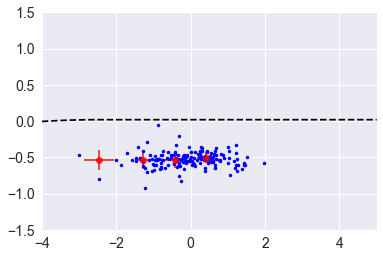

In [4]:
##################################################
fig = plt.figure(figsize=(6, 4))
plt.plot(pc0,delta2, 'b.')
plt.ylim([-1.5,1.5])
plt.xlim([-4,5])

a0, b0, c0  = np.polyfit(pc0, delta2, 2)
xx = np.linspace(-4,5,50)
yy = Fdelta([a0,b0,c0],xx)
plt.plot(xx,yy, 'k--')

for i in range(-4,5):
    
    x = []
    y = []
    for ii in range(len(pc0)):
        xi = pc0[ii]
        if xi>=i and xi<i+1:
            x.append(xi)
            y.append(delta2[ii])
    if len(x)>0:
        plt.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)

error = delta2-Fdelta([a0,b0,c0],pc0)
rms = np.sqrt(np.mean(np.square(error)))
print(rms)   # 0.23

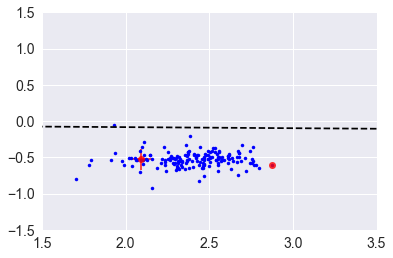

In [5]:
##################################################
fig = plt.figure(figsize=(6, 4))
plt.plot(logWimx,delta2, 'b.')
plt.ylim([-1.5,1.5])
plt.xlim([1.5,3.5])

a0, b0  = np.polyfit(logWimx, delta2, 1)
xx = np.linspace(1,4,50)
yy = a0*xx+b0
plt.plot(xx,yy, 'k--')

for i in np.arange(1,4,0.3):
    
    x = []
    y = []
    for ii in range(len(logWimx)):
        xi = logWimx[ii]
        if xi>=i and xi<i+0.3:
            x.append(xi)
            y.append(delta2[ii])
    if len(x)>0:
        plt.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)

error = delta2-(a0*logWimx+b0)
rms = np.sqrt(np.mean(np.square(error)))
print(rms)   # 0.24